<a href="https://colab.research.google.com/github/ikyath/RNN_Introduction_Fundamentals/blob/master/StockPrediction_Bidirectional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lets work on the same problem of predicting the trends in apple stocks using Bidirectional LSTM**

**Installing the alpha-vantage api**

In [9]:
!pip install alpha-vantage

**Importing the libraries**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Bidirectional
from alpha_vantage.timeseries import TimeSeries

In [0]:
def alpha_vanatage(symbol,outputsize):
  ts = TimeSeries(key='5W7LO5BBKDO63VCC', output_format='pandas',indexing_type='integer')
  dataset, meta_data = ts.get_daily(symbol=symbol, outputsize=outputsize)
  return dataset


Lets look at the size of the dataset

In [12]:
dataset = alpha_vanatage('AAPl','full')
print(dataset.shape)

(5032, 6)


We have 5036 records with 6 features 

## **Data Preprocessing**

Lets have a peek at first few rows of the dataset

In [13]:
dataset.head()

,index,1. open,2. high,3. low,4. close,5. volume
index,,,,,,
0,2020-04-23,275.87,281.750,274.87,275.03,30856632.0
1,2020-04-22,273.61,277.900,272.20,276.10,29264342.0
2,2020-04-21,276.28,277.250,265.43,268.37,45247893.0
3,2020-04-20,277.95,281.680,276.85,276.93,32503750.0
4,2020-04-17,284.69,286.945,276.86,282.80,53812478.0


Lets sort the data in increasing order of date

In [0]:
dataset = dataset.iloc[::-1]

In [0]:
dataset = dataset.set_index(pd.Series(range(dataset.shape[0])))

In [16]:
dataset.head()

,index,1. open,2. high,3. low,4. close,5. volume
0,2000-04-24,115.00,120.50,114.75,120.50,3960900.0
1,2000-04-25,122.12,128.75,122.06,128.31,3496800.0
2,2000-04-26,126.62,128.00,120.00,121.31,3276000.0
3,2000-04-27,117.19,127.00,116.58,126.75,2916100.0
4,2000-04-28,127.12,127.50,121.31,124.06,2228400.0


Lets us visualize the complete trend from 2000 to current day.

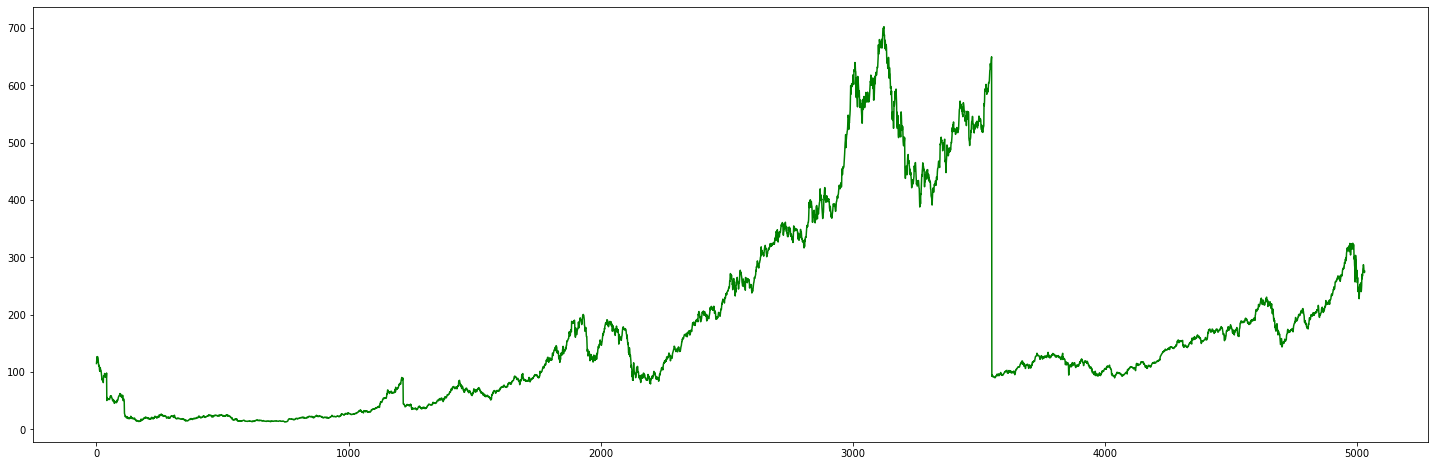

In [17]:
plt.figure(figsize=(25,8))
plt.plot(dataset['1. open'],color='green')

We are trying to predict the trend in last 60days, 
Please find below the actual trend in last 60 days

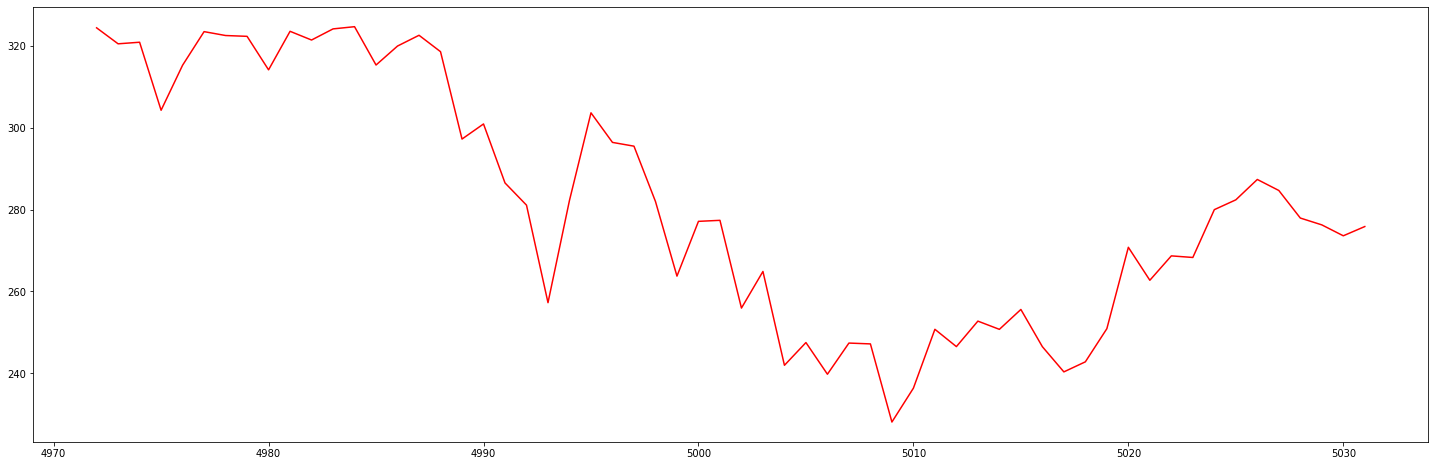

In [18]:
plt.figure(figsize=(25,8))
plt.plot(dataset.iloc[-60:,1:2],color='red')

In [19]:
dataset.head()

,index,1. open,2. high,3. low,4. close,5. volume
0,2000-04-24,115.00,120.50,114.75,120.50,3960900.0
1,2000-04-25,122.12,128.75,122.06,128.31,3496800.0
2,2000-04-26,126.62,128.00,120.00,121.31,3276000.0
3,2000-04-27,117.19,127.00,116.58,126.75,2916100.0
4,2000-04-28,127.12,127.50,121.31,124.06,2228400.0


Creating the train and test data from the original dataset

In [0]:
dataset_train = dataset.iloc[:4971,:]

In [0]:
dataset_test = dataset.iloc[-60:,:]

In [22]:
print(dataset_train.shape,dataset_test.shape)

(4971, 6) (60, 6)


To create a numpy array of train values

In [0]:
train = dataset_train.iloc[:,1:2].values

We have a numpy array of one column

In [24]:
train[:10]

array([[115.  ],
       [122.12],
       [126.62],
       [117.19],
       [127.12],
       [124.87],
       [123.25],
       [118.94],
       [115.12],
       [110.81]])

## **Feature Scaling**

Using MinMaxScalar to normalize the data

In [0]:
scale = MinMaxScaler(feature_range=(0,1))

In [0]:
train_scaled = scale.fit_transform(train)

In [27]:
train_scaled[:10]

array([[0.14796496],
       [0.15829248],
       [0.1648197 ],
       [0.15114154],
       [0.16554495],
       [0.16228134],
       [0.15993154],
       [0.1536799 ],
       [0.14813902],
       [0.14188738]])

## **Creating a training data structure** 

This means that model is going to take 120 stock prices before time T in which RNNs are going to learn and understand some correlations and based on its understanding its going to predict the next output

We can try the above by considering different timestamps

In [0]:
time_len = 120

In [0]:
X_train = []
y_train = []
for i in range(time_len,dataset_train.shape[0]):
    X_train.append(train_scaled[i-time_len:i,0])
    y_train.append(train_scaled[i,0])
X_train,y_train = np.array(X_train),np.array(y_train) #converting to numpy arrays so that they can be accepted in futute to our RNNs

X_train will contain the 120 previous stock prices for current financial day.

y_train will contain will contain stock price for current financial day

In [30]:
print(X_train[0],y_train[0])

[0.14796496 0.15829248 0.1648197  0.15114154 0.16554495 0.16228134
 0.15993154 0.1536799  0.14813902 0.14188738 0.14374402 0.14116214
 0.13209654 0.12819471 0.1349105  0.13789852 0.13276377 0.13145833
 0.13055902 0.12511967 0.11714195 0.11242784 0.10617621 0.10952685
 0.1088016  0.10825041 0.10716254 0.09973601 0.11714195 0.11650373
 0.11456006 0.11695338 0.12275536 0.12149343 0.12094224 0.11342868
 0.11850541 0.11351571 0.11677932 0.11251487 0.12403179 0.05440805
 0.06202315 0.05916568 0.05730904 0.05916568 0.05848394 0.05812132
 0.0577587  0.05677236 0.05839691 0.05730904 0.05743959 0.05961533
 0.06383627 0.06547533 0.06601201 0.06402483 0.06564939 0.06601201
 0.06121087 0.06093528 0.06000696 0.05739607 0.05413246 0.05345073
 0.05368281 0.05698993 0.05246439 0.05413246 0.05223231 0.04724261
 0.05291404 0.05060776 0.05069479 0.05097038 0.05078182 0.04909924
 0.05018711 0.04969395 0.04915726 0.051333   0.05568449 0.05404543
 0.05459662 0.05581503 0.06045662 0.06311102 0.06419889 0.0651

We can see our dataframe with 120 previews of previous stock of the taken financial day

We need to create the new dimensionality of the above mentioned new data structure, because that exactly is accepted by the future recurrent network. [Reference](https://keras.io/layers/recurrent/)

In [0]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

## **Model for a Bidirectional LSTM**

In [0]:
model = Sequential()
model.add(Bidirectional(LSTM(units=50,return_sequences=True,input_shape = (X_train.shape[1],1))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

Compiling the model, specifying the optimizer and loss function

In [0]:
model.compile(optimizer='RMSProp',loss='mean_squared_error')

RMSProp optimizer is preferred for RNNs [Reference](https://keras.io/optimizers/)

Now lets train our model

In [34]:
model.fit(X_train,y_train,epochs=20,batch_size=32)

Epoch 1/20
4851/4851 [==============================] - 70s 14ms/step - loss: 0.0064
Epoch 2/20
4851/4851 [==============================] - 69s 14ms/step - loss: 0.0032
Epoch 3/20
4851/4851 [==============================] - 69s 14ms/step - loss: 0.0025
Epoch 4/20
4851/4851 [==============================] - 69s 14ms/step - loss: 0.0021
Epoch 5/20
4851/4851 [==============================] - 69s 14ms/step - loss: 0.0019
Epoch 6/20
4851/4851 [==============================] - 69s 14ms/step - loss: 0.0018
Epoch 7/20
4851/4851 [==============================] - 69s 14ms/step - loss: 0.0016
Epoch 8/20
4851/4851 [==============================] - 69s 14ms/step - loss: 0.0014
Epoch 9/20
4851/4851 [==============================] - 68s 14ms/step - loss: 0.0014
Epoch 10/20
4851/4851 [==============================] - 68s 14ms/step - loss: 0.0014
Epoch 11/20
4851/4851 [==============================] - 68s 14ms/step - loss: 0.0012
Epoch 12/20
4851/4851 [==============================] - 68s 14

Lets look at the network architecture

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 120, 100)          20800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 120, 100)          60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 120, 100)          60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100)              

## **Creating a test data structure - Bidirectional RNN**

Get the real stock price from testing dataset and convert it to numpy array

In [0]:
real_stock_price = dataset_test.iloc[:,1:2].values

In [0]:
dataset_total = pd.concat((dataset_train['1. open'],dataset_test['1. open']),axis=0)

In [0]:
inputs = dataset_total[len(dataset_total)-len(dataset_test)-120:].values

In [39]:
inputs.shape

(180,)

As mentioned above we have to change the input shape

In [0]:
inputs = inputs.reshape(-1,1)

In [41]:
inputs.shape

(180, 1)

As done before we are doing feature scaling for the this data too.

In [0]:
inputs = scale.transform(inputs)

Creating X_test datastructure similar to X_train

In [0]:
X_test = []
for i in range(120,120+60):
    X_test.append(inputs[i-120:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

## **Prediction - Bidirectional RNN**

In [0]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scale.inverse_transform(predicted_stock_price) #inversing the scaling

## **Visualizing the results - Bidirectional RNN**

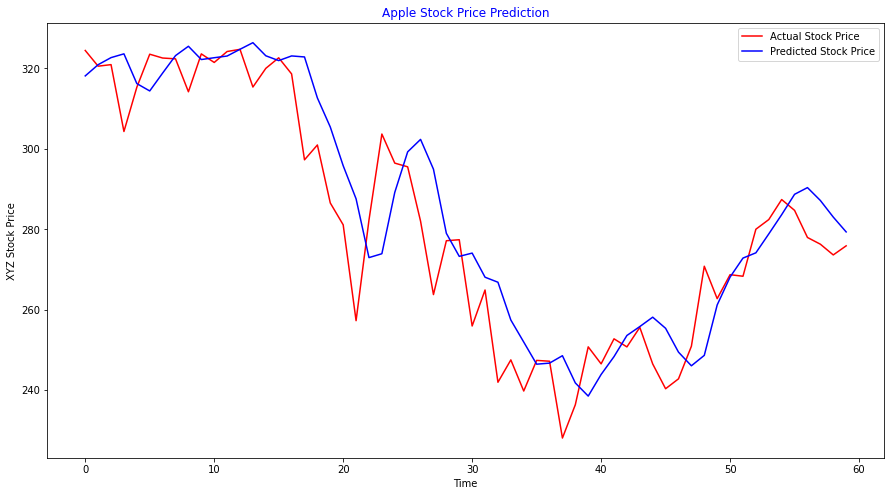

In [45]:
plt.figure(figsize=(15,8))
plt.plot(real_stock_price,color='red',label='Actual Stock Price')
plt.plot(predicted_stock_price,color='blue',label='Predicted Stock Price')
plt.title('Apple Stock Price Prediction',color='blue')
plt.xlabel('Time')
plt.ylabel('XYZ Stock Price')
plt.legend()
plt.show()

From the above graph, it is evident that there is an improvement in how closely we are able to predict the trend in the stock price changes using Bidirectional LSTM compared to LSTM.